In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Conv2DTranspose, concatenate
from tensorflow import keras
from tensorflow.keras import regularizers

In [2]:
dataset_path = "/kaggle/input/brainstroke/dataset"
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                      batch_size=32,
                                                      label_mode="categorical",
                                                      shuffle=True,
                                                      color_mode="grayscale")
print(dataset.class_names)
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

Found 6650 files belonging to 3 classes.
['KanamaVeriSeti_PNG', 'inmeYokVeriSeti_PNG', 'iskemiVeriSeti_PNG']


In [3]:
shape =()
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels shape:", labels.shape)
    shape = images.shape[1:]

Train batch shape: (32, 256, 256, 1)
Train labels shape: (32, 3)


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus[0].name}")
else:
    print("No GPU found, using CPU")

Using GPU: /physical_device:GPU:0


In [5]:
def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    weight = 32
    nb_filter = [weight, weight * 2, weight * 4, weight * 8, weight * 16]

    inputs = Input(shape=input_size)

    # Encoding (Contracting Path)
    conv1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(conv5)

    # Decoding (Expanding Path)
    up6 = concatenate([Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv9)
    # Output Layer
    gap = GlobalAveragePooling2D()(conv9)
    dense1 = Dense(128, activation='relu')(gap)
    dropout1 = Dropout(0.5)(dense1)  # Optional dropout
    output = Dense(3, activation='softmax')(dropout1)

    model = keras.Model(inputs=[inputs], outputs=[output])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [6]:
strategy = tf.distribute.MirroredStrategy()

print("Number of GPUs:", strategy.num_replicas_in_sync)

Number of GPUs: 2


In [7]:
with strategy.scope():
    model = unet(input_size=shape)
    model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,764,099 (29.62 MB)

 Trainable params: 7,764,099 (29.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_ds, epochs=100, batch_size=8, validation_data=val_ds)
model.save('/kaggle/working/UNET_Model_100epochs.keras')

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 103s 513ms/step - accuracy: 0.6356 - loss: 1.0361 - val_accuracy: 0.6532 - val_loss: 0.8641
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 548ms/step - accuracy: 0.6671 - loss: 0.8541 - val_accuracy: 0.6487 - val_loss: 0.8662
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 92s 555ms/step - accuracy: 0.6612 - loss: 0.8579 - val_accuracy: 0.6816 - val_loss: 0.8076
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 93s 558ms/step - accuracy: 0.6613 - loss: 0.8459 - val_accuracy: 0.6413 - val_loss: 0.8655
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 551ms/step - accuracy: 0.6633 - loss: 0.8371 - val_accuracy: 0.6607 - val_loss: 0.8154
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 550ms/step - accuracy: 0.6638 - loss: 0.8305 - val_accuracy: 0.6726 - val_loss: 0.7936
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 92s 554ms/step - accuracy: 0.6643 - loss: 0.8296 - val_accuracy: 0.6652 - val_loss: 0.8010
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 548ms/step - accuracy: 0.6655 

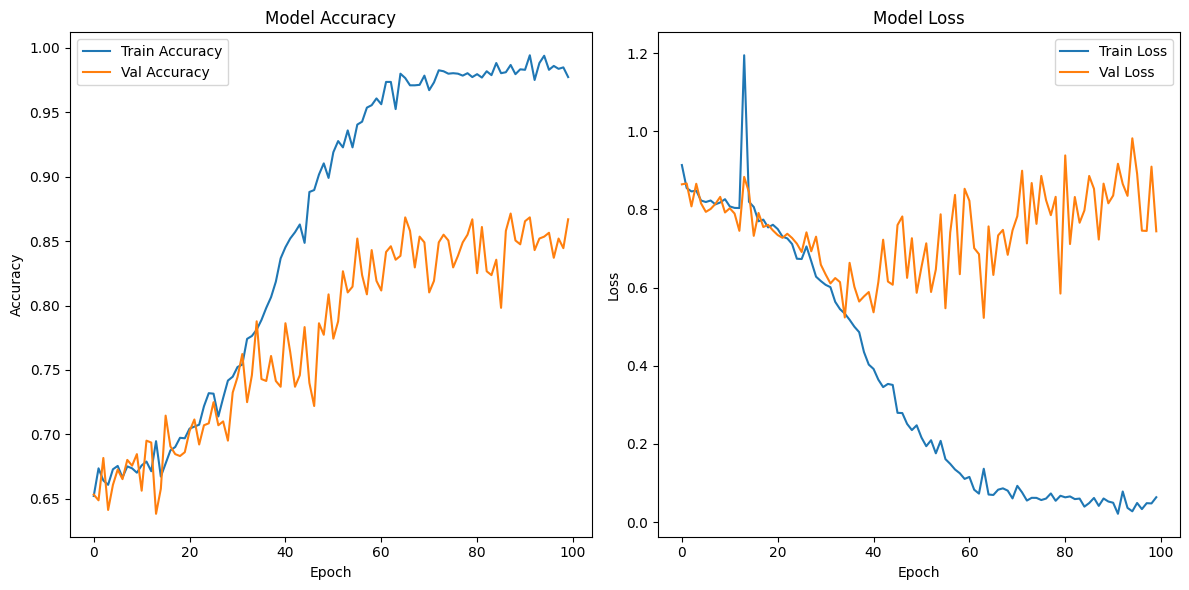

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()